In [1]:
# %cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

# Imports generales

In [2]:
import time
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms.v2 as T
from icecream import ic
from matplotlib import pyplot as plt

import bwb.plotters as plotters
from bwb.config import conf
from bwb.distributions.posterior_samplers import NUTSPosteriorSampler as NUTSPosteriorPiN

# Definir constantes y logger

In [3]:
from bwb import _logging as logging


# Tunneable params
RUN_MCMC = True
BURN = 1_000
NUM_SAMPLES = 10_000
N_WALKERS = 4
TAKE_EVERY = 5

# Paths
CURR_PATH = Path("..")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 
MCMC_PATH = CURR_PATH / "saved_mcmc"
NUTS_PATH = MCMC_PATH / "NUTS"

# Seed
SEED = 4102165607616432379
print(f"{SEED = }")
torch.manual_seed(SEED)

# Configuration
conf.use_single_precision()
conf.use_gpu()
conf.set_eps(1e-8)
print(conf)

log = logging.get_logger(__name__)

SEED = 4102165607616432379
Config(dtype=torch.float32, device=cuda:0, eps=1.00e-08)


# Dataset

In [4]:
from quick_torch import QuickDraw
from bwb.distributions.models import ModelDataset
import bwb.distributions.distribution_samplers as distr_samplers


ds = QuickDraw(
    Path("./data"),
    categories="face",
    download=True,
    transform=T.Compose(
        [
            T.ToImage(),
            T.ToDtype(conf.dtype, scale=True),
            T.Lambda(lambda x: x.squeeze()),
        ]
    )
)

ds = ModelDataset(ds)
ds_sampler = distr_samplers.UniformDiscreteSampler().fit(ds)


face = ds_sampler.draw()
print(face)

face

DistributionDraw(shape: (28, 28), device: cuda:0, dtype: torch.float32)


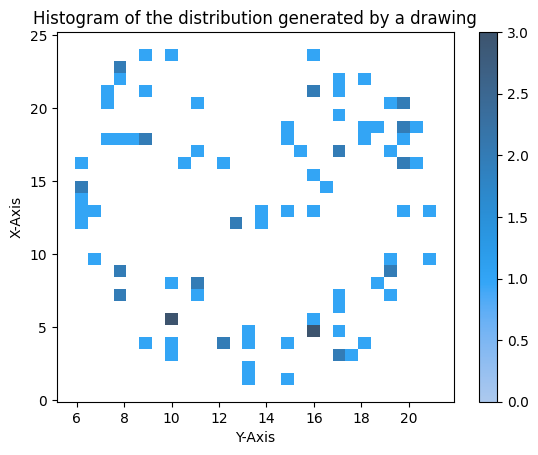

In [5]:
def get_sample(sampler, n_sample):
    face = sampler.draw()

    data = face.sample((n_sample,))

    shape = face.shape
    data_coords = face.enumerate_support_()[data].cpu().numpy() + np.random.randn(len(data), 2) * 0.1

    plotters.plot_histogram_from_points(data_coords, rotate=True, shape=shape, histplot_kwargs=dict(bins=28))
    plt.show()

    return face, data

face, data = get_sample(ds_sampler, 100)
face

# Importar redes

In [6]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = conf.device

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)


G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

In [7]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cuda:0)

torch.float32
torch.float32


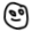

In [8]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T

z = noise_sampler(1)
m = G(z)
print(m.dtype)
dtype = z.dtype

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(dtype),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(dtype),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
    # T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

out: DistributionDraw = transform_out(m)
print(out.dtype)
out

In [9]:
from bwb.distributions.distribution_samplers import GeneratorDistribSampler

distr_sampler = GeneratorDistribSampler()
distr_sampler.fit(G, transform_out_, noise_sampler)
distr_sampler.transform_noise(z)
distr_sampler.rvs(3)

[DistributionDraw(shape: (32, 32), device: cuda:0, dtype: torch.float32),
 DistributionDraw(shape: (32, 32), device: cuda:0, dtype: torch.float32),
 DistributionDraw(shape: (32, 32), device: cuda:0, dtype: torch.float32)]

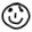

In [10]:
distr_sampler.draw()

# Experimentos

## Experimento 1

In [11]:
EXPERIMENT = 1
NUTS_POSTERIOR_PATH = NUTS_PATH / F"exp={EXPERIMENT}-burn={BURN:_}-num_samples={NUM_SAMPLES:_}-n_walkers={N_WALKERS}"
NUTS_POSTERIOR_PATH

PosixPath('../saved_mcmc/NUTS/exp=1-burn=1_000-num_samples=10_000-n_walkers=4')

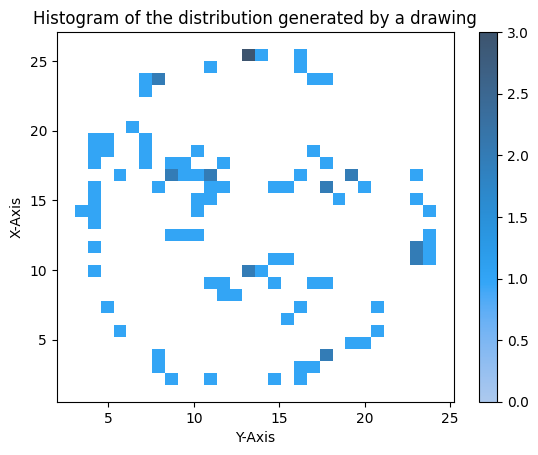

In [12]:
face, data = get_sample(ds_sampler, 100)
face

In [ ]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorPiN(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data
    ).run(
        n_steps=NUM_SAMPLES
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorPiN.load(NUTS_POSTERIOR_PATH)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04207880049943924--- |   998/11000 | 73.39       
0d:00:02:25 | 0d:00:00:00 | #################### | 11000/11000 | 75.71       
Acceptance Rate 0.47
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.03664027526974678--- |   997/11000 | 73.06       
0d:00:02:26 | 0d:00:00:00 | #################### | 11000/11000 | 75.33       
Acceptance Rate 0.49
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.056993577629327774-- |  1000/11000 | 76.81       
0d:00:02:19 | 0d:00:00:00 | #################### | 11000/11000 | 78.67       
Acceptance Rate 0.45
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

In [ ]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

In [ ]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / TAKE_EVERY))

In [ ]:
max_images = 36
plotters.plot_list_of_draws(post_pi_n.rvs(max_images), n_rows=3, n_cols=12)
print()

In [ ]:
post_pi_n

## Experimento 2

In [ ]:
EXPERIMENT = 2
NUTS_POSTERIOR_PATH = NUTS_PATH / F"exp={EXPERIMENT}-burn={BURN:_}-num_samples={NUM_SAMPLES:_}-n_walkers={N_WALKERS}"
NUTS_POSTERIOR_PATH

In [ ]:
face, data = get_sample(ds_sampler, 100)
face

In [ ]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorPiN(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data
    ).run(
        n_steps=NUM_SAMPLES
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorPiN.load(NUTS_POSTERIOR_PATH)

post_pi_n

In [ ]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

In [ ]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / TAKE_EVERY))

In [ ]:
max_images = 36
plotters.plot_list_of_draws(post_pi_n.rvs(max_images), n_rows=3, n_cols=12)
print()

In [ ]:
post_pi_n

## Experimento 3

In [ ]:
EXPERIMENT = 3
NUTS_POSTERIOR_PATH = NUTS_PATH / F"exp={EXPERIMENT}-burn={BURN:_}-num_samples={NUM_SAMPLES:_}-n_walkers={N_WALKERS}"
NUTS_POSTERIOR_PATH

In [ ]:
face, data = get_sample(ds_sampler, 100)
face

In [ ]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorPiN(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data
    ).run(
        n_steps=NUM_SAMPLES
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorPiN.load(NUTS_POSTERIOR_PATH)

post_pi_n

In [ ]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

In [ ]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / TAKE_EVERY))

In [ ]:
max_images = 36
plotters.plot_list_of_draws(post_pi_n.rvs(max_images), n_rows=3, n_cols=12)
print()

In [ ]:
post_pi_n

## Experimento 4

In [ ]:
EXPERIMENT = 4
NUTS_POSTERIOR_PATH = NUTS_PATH / F"exp={EXPERIMENT}-burn={BURN:_}-num_samples={NUM_SAMPLES:_}-n_walkers={N_WALKERS}"
NUTS_POSTERIOR_PATH

In [ ]:
face, data = get_sample(ds_sampler, 100)
face

In [ ]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorPiN(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data
    ).run(
        n_steps=NUM_SAMPLES
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorPiN.load(NUTS_POSTERIOR_PATH)

post_pi_n

In [ ]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

In [ ]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / TAKE_EVERY))

In [ ]:
max_images = 36
plotters.plot_list_of_draws(post_pi_n.rvs(max_images), n_rows=3, n_cols=12)
print()

In [ ]:
post_pi_n

## Experimento 5

In [ ]:
EXPERIMENT = 5
NUTS_POSTERIOR_PATH = NUTS_PATH / F"exp={EXPERIMENT}-burn={BURN:_}-num_samples={NUM_SAMPLES:_}-n_walkers={N_WALKERS}"
NUTS_POSTERIOR_PATH

In [ ]:
face, data = get_sample(ds_sampler, 100)
face

In [ ]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorPiN(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data
    ).run(
        n_steps=NUM_SAMPLES
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorPiN.load(NUTS_POSTERIOR_PATH)

post_pi_n

In [ ]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

In [ ]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / TAKE_EVERY))

In [ ]:
max_images = 36
plotters.plot_list_of_draws(post_pi_n.rvs(max_images), n_rows=3, n_cols=12)
print()

In [ ]:
post_pi_n